<a href="https://colab.research.google.com/github/SSSSeki/-/blob/master/visual_rule_induction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rule Generation

In [1]:
from numpy import info
import random
import pandas as pd

rule_list = list()
info_list = list()
def generate_rule():
  objects_list = ["sphere","cube","cylinder","cone"]
  attr_x_list = ["color","size","pos"]
  attr_y_list = ["color","size","pos"]

  shape = ["sphere","cube","cylinder","cone"]
  color = ["red","yellow","orange","green","blue","purple","white","gray"]
  size = ["largest","smallest"]
  pos = ["far-left","far-right","front","back"]

  x = random.randint(0,len(attr_x_list)-1)
  attr_x = ''
  if attr_x_list[x] == "color":
    attr_x = color[random.randint(0,len(color)-1)]
  elif attr_x_list[x] == "size":
    attr_x = size[random.randint(0,len(size)-1)]
  elif attr_x_list[x] == "pos":
    attr_x = pos[random.randint(0,len(pos)-1)]

  o = random.randint(0,len(objects_list)-1)
  objects = objects_list[o]

  #if attr_x and attr_y discribe the same attibute, then rerandom
  y = random.randint(0,len(attr_y_list)-1)
  while(attr_x_list[x] == attr_y_list[y]):
    y = random.randint(0,len(attr_y_list)-1)
  
  attr_y = ''
  if attr_y_list[y] == "color":
    attr_y = color[random.randint(0,len(color)-1)]
  elif attr_y_list[y] == "size":
    attr_y = size[random.randint(0,len(size)-1)]
  elif attr_y_list[y] == "pos":
    attr_y = pos[random.randint(0,len(pos)-1)]

  rule = ''
  #one pattern, need more robust
  if attr_x!='' and attr_y!='':
    rule = attr_x+" "+objects+" must be "+ attr_y
  info_list.append([attr_x_list[x],attr_x,objects,attr_y_list[y],attr_y])
  if rule!='':
    rule_list.append(rule)

#generation 200 rules
for i in range(0,200):
  generate_rule()


#duplicated 1.0
df1 = pd.DataFrame(rule_list,columns=['rules'])
df2 = pd.DataFrame(info_list,columns=['attr_x','x','obj','attr_y','y'])
df = pd.concat([df1,df2],axis=1)
df = df[~(df['rules'].isnull())]
ruleset = df['rules']
#print(ruleset)
print(df.head())

                               rules attr_x          x       obj attr_y  \
0  far-right cylinder must be yellow    pos  far-right  cylinder  color   
1       green cone must be far-right  color      green      cone    pos   
2       purple cube must be smallest  color     purple      cube   size   
3   far-right sphere must be largest    pos  far-right    sphere   size   
4     back cylinder must be smallest    pos       back  cylinder   size   

           y  
0     yellow  
1  far-right  
2   smallest  
3    largest  
4   smallest  


# Visual Rule Induction Benchmark

In [2]:
!pip install pyrender trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 669.2/669.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.9/978.9 KB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 968.6/968.6 KB 54.1 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=a4df48c483e8141cdb3fda8c091ea5999d2957434c52a839536294a2324fbbbf
  Stored in directory: /root/.cache/pip/wheels/85/ff/54/41f30bb227befd3dde302de39f9ba042589e8b4f93723107f2
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.6
    Uninstalling PyOpenGL-3.1.6:
      Successfully uninstalled PyOpenGL-3.1.6


In [3]:
from tqdm.notebook import tqdm

In [4]:
import random
from pprint import pprint

SHAPE = "cylinder sphere cube cone".split()
COLOR = "red yellow orange green blue purple gray white".split()
SIZE = [x/10 for x in range(3, 11)]
NUM_OBJECTS = range(2, 6)
POS = [x/10 for x in range(1,10,2)]


def randchoice(X):
    return random.sample(X, 1)[0]

def generate_random_scenes(n_scenes):
    scenes = list()

    for t in range(n_scenes):
        scene = list()

        # Determine the number of objects.
        num_objects = randchoice(NUM_OBJECTS)

        # Non-overlapping random position generator.
        randpos = [(x/10, y/10) for x in range(1, 10, 2) for y in range(1, 10, 2)]
        random.shuffle(randpos)

        # Generate random objects.
        for i in range(num_objects):
            scene.append({
                "_id": i,
                "shape": randchoice(SHAPE),
                "color": randchoice(COLOR),
                "size": randchoice(SIZE),
                "pos_x": randchoice(POS),
                "pos_y": randchoice(POS),
            })
        scenes.append(scene)

    return scenes

In [5]:
import pandas as pd

def rule_sat(obj, rule, df_scene):
    """
    -1: Not fired
    0: Fired, but not satisfied
    1: Fired and satisfied
    """

    # First, check if the antecedent of the rule describes the given object.
    matched_objects = rule[0](df_scene)

    if len(matched_objects) == 0:
        return -1

    # If so, check if the consequences holds.
    return rule[1](matched_objects)

#something wrong with fitting
def is_satisfied(scene, rule):
    satisfied = True
    rule_fired = False
    df_scene = pd.DataFrame(scene)

    for obj in scene:
        is_obj_satisfied = rule_sat(obj, rule, df_scene)

        if is_obj_satisfied == -1:
            continue

        satisfied &= is_obj_satisfied
        rule_fired = True

    return satisfied and rule_fired

In [6]:
# single rule test
# "The smallest square is always red-colored."
rule = (lambda objects: objects[(objects["shape"] == "sphere") & (objects["size"] == objects["size"].min())],
        lambda matched: (matched["color"] == "red").all())

all_satisfied_scenes = [
    scene for scene in tqdm(generate_random_scenes(1000))
    if is_satisfied(scene, rule)
]
len(all_satisfied_scenes)

  0%|          | 0/1000 [00:00<?, ?it/s]

33

In [24]:
#rule pattern
#this function needs optimize

def selection(attr_x,x,obj,attr_y,y):
  #size-color
  if attr_x == "size" and attr_y == "color":
    if x == "smallest":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].min())],
        lambda matched: (matched[attr_y] == y).all())
    elif x == "largest":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].max())],
        lambda matched: (matched[attr_y] == y).all())
  
  #color_size
  elif attr_x == "color" and attr_y == "size":
    if y == "smallest":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched[attr_y] == matched["size"].min()).all())
    elif y == "largest":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched[attr_y] == matched["size"].max()).all())
      
  #color_pos
  elif attr_x == "color" and attr_y == "pos":
    if y == "far-left":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched["pos_x"] == matched["pos_x"].min()).all())
    elif y == "far-right":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched["pos_x"] == matched["pos_x"].max()).all())
    elif y == "front":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched["pos_y"] == matched["pos_y"].min()).all())
    elif y == "back":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects[attr_x] == x)],
        lambda matched: (matched["pos_y"] == matched["pos_y"].max()).all())
  #size_pos
  elif attr_x == "size" and attr_y == "pos":
    if x == "smallest":
      if y == "far-left":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].min())],
          lambda matched: (matched["pos_x"] == matched["pos_x"].min()).all())
      elif y == "far-right":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].min())],
          lambda matched: (matched["pos_x"] == matched["pos_x"].max()).all())
      elif y == "front":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].min())],
          lambda matched: (matched["pos_y"] == matched["pos_y"].min()).all())
      elif y == "back":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].min())],
          lambda matched: (matched["pos_y"] == matched["pos_y"].max()).all())
    elif x == "largest":
      if y == "far-left":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].max())],
          lambda matched: (matched["pos_x"] == matched["pos_x"].min()).all())
      elif y == "far-right":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].max())],
          lambda matched: (matched["pos_x"] == matched["pos_x"].max()).all())
      elif y == "front":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].max())],
          lambda matched: (matched["pos_y"] == matched["pos_y"].min()).all())
      elif y == "back":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["size"] == objects["size"].max())],
          lambda matched: (matched["pos_y"] == matched["pos_y"].max()).all())
  #pos_size
  elif attr_x == "pos" and attr_y == "size":
    if x == "far-left":
      if y == "smallest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].min())],
          lambda matched: (matched[attr_y] == matched["size"].min()).all())
      elif y == "largest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].min())],
          lambda matched: (matched[attr_y] == matched["size"].max()).all())

    elif x == "far-right":
      if y == "smallest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].max())],
          lambda matched: (matched[attr_y] == matched["size"].min()).all())
      elif y == "largest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].max())],
          lambda matched: (matched[attr_y] == matched["size"].max()).all())
    elif x == "front":
      if y == "smallest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].min())],
          lambda matched: (matched[attr_y] == matched["size"].min()).all())
      elif y == "largest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].min())],
          lambda matched: (matched[attr_y] == matched["size"].max()).all())
    elif x == "back":
      if y == "smallest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].max())],
          lambda matched: (matched[attr_y] == matched["size"].min()).all())
      elif y == "smallest":
        rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].max())],
          lambda matched: (matched[attr_y] == matched["size"].max()).all())
  #pos_color
  elif attr_x == "pos" and attr_y == "color":
    if x == "far-left":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].min())],
        lambda matched: (matched[attr_y] == y).all())
    elif x == "far-right":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_x"] == objects["pos_x"].max())],
        lambda matched: (matched[attr_y] == y).all())
    elif x == "front":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].min())],
        lambda matched: (matched[attr_y] == y).all())
    elif x == "back":
      rulesid = (lambda objects: objects[(objects["shape"] == obj) & (objects["pos_y"] == objects["pos_y"].max())],
        lambda matched: (matched[attr_y] == y).all())
    

  all_satisfied_scenes = [
    scene for scene in tqdm(generate_random_scenes(1000))
    if is_satisfied(scene, rulesid)
  ]

  print(len(all_satisfied_scenes))
  return all_satisfied_scenes

#test: rules to scences paremeters
#orange sphere must be largest
t1 = selection("color","orange","sphere","size","largest")
#smallest cube must be blue
t2 = selection("size","smallest","cube","color","blue")
#front cube must be purple
t3 = selection("pos","front","cube","color","purple")



  0%|          | 0/1000 [00:00<?, ?it/s]

102


  0%|          | 0/1000 [00:00<?, ?it/s]

29


  0%|          | 0/1000 [00:00<?, ?it/s]

36


In [30]:
#generation
all_satisfied_scenes_list = []
num = df.shape[0]/20
for i in range(int(num)):
  all_satisfied_scenes = selection(df['attr_x'][i],df['x'][i],df['obj'][i],df['attr_y'][i],df['y'][i])
  all_satisfied_scenes_list.append(all_satisfied_scenes)
print(df["attr_x"][9])
print(df["rules"][9])

  0%|          | 0/1000 [00:00<?, ?it/s]

33


  0%|          | 0/1000 [00:00<?, ?it/s]

97


  0%|          | 0/1000 [00:00<?, ?it/s]

98


  0%|          | 0/1000 [00:00<?, ?it/s]

284


  0%|          | 0/1000 [00:00<?, ?it/s]

298


  0%|          | 0/1000 [00:00<?, ?it/s]

31


  0%|          | 0/1000 [00:00<?, ?it/s]

45


  0%|          | 0/1000 [00:00<?, ?it/s]

93


  0%|          | 0/1000 [00:00<?, ?it/s]

314


  0%|          | 0/1000 [00:00<?, ?it/s]

88
color
red cube must be front


# Rendering with pyrender

far-right cylinder must be yellow


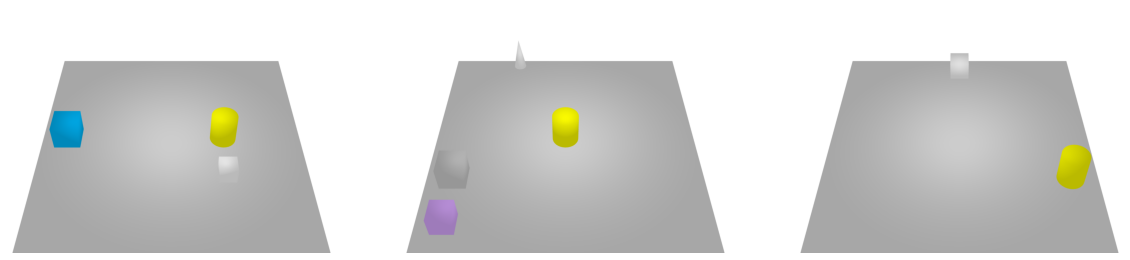

green cone must be far-right


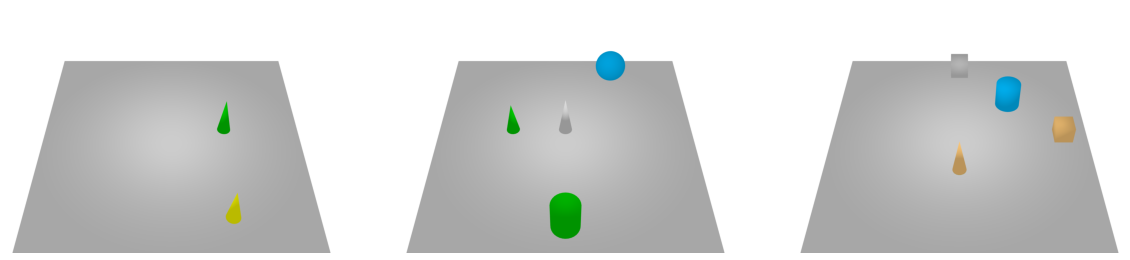

purple cube must be smallest


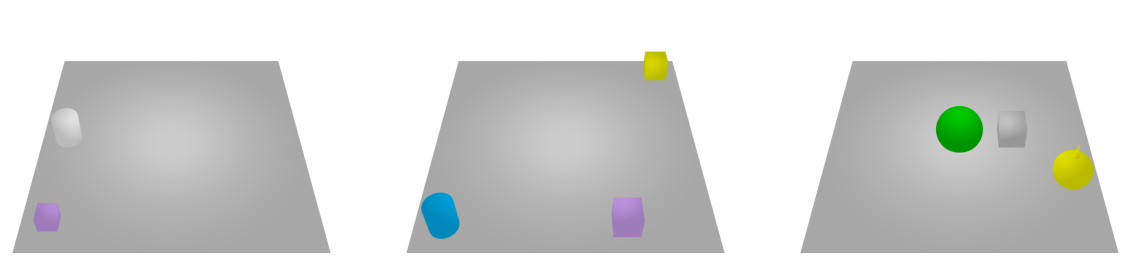

far-right sphere must be largest


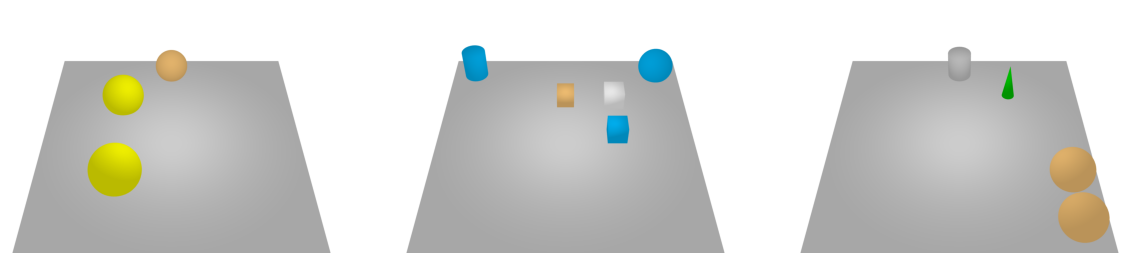

back cylinder must be smallest


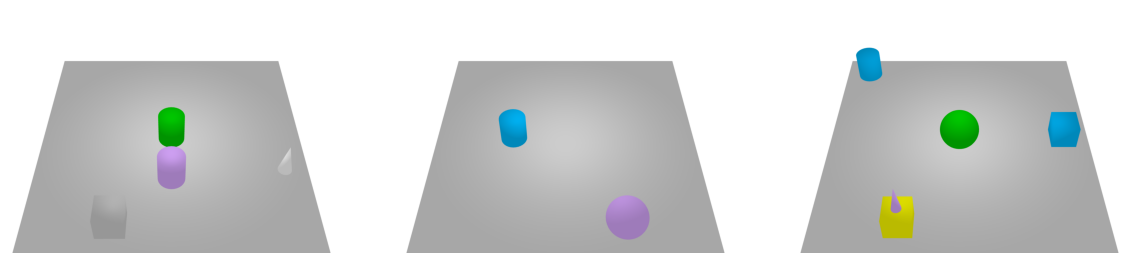

largest sphere must be gray


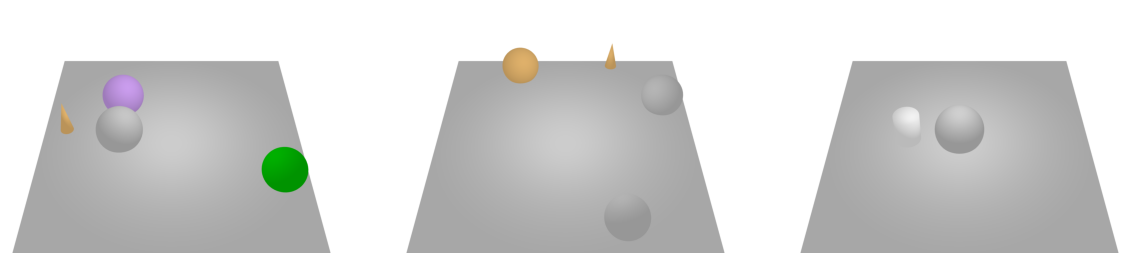

front cone must be orange


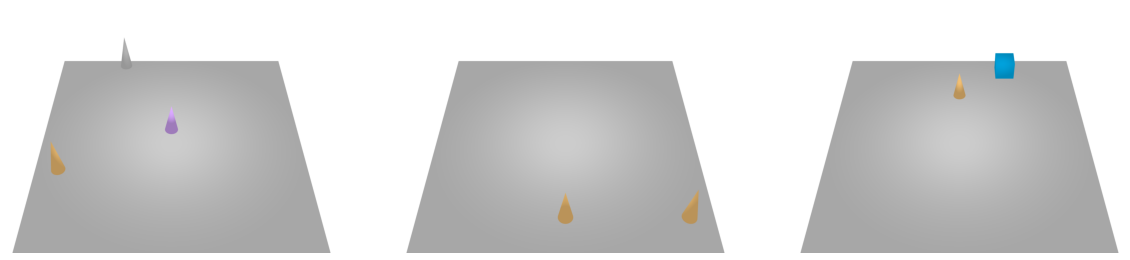

yellow sphere must be front


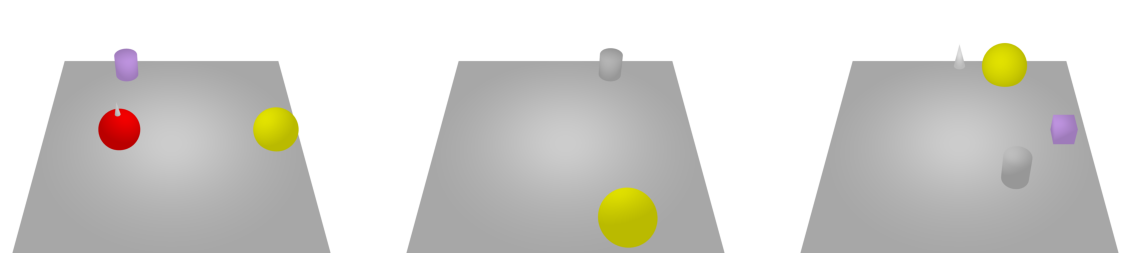

back cylinder must be smallest


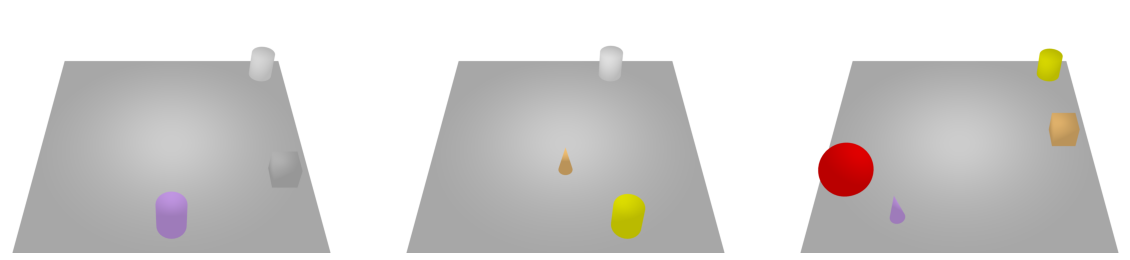

red cube must be front


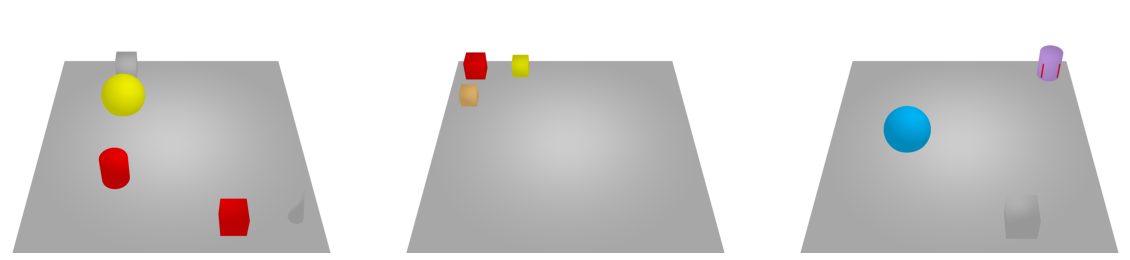

In [31]:
# Memo: X axis: left-right, Y axis: front-back, Z axis:top-bottom
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"

import numpy as np
import trimesh
import pyrender
from matplotlib import pyplot as plt

COLORS = {
    "red": (255, 0, 0),
    "green": (0, 153, 0),
    "blue": (0, 128, 255),
    "purple": (178, 102, 255),
    "orange": (255, 153, 51),
    "gray": (160, 160, 160),
    "yellow": (255, 255, 0),
    "white": (255, 255, 255),
}


def create_mesh(obj):
    if obj["shape"] == "cylinder":
        return trimesh.creation.cylinder(radius=0.1, height=0.2 + 0.1*obj['size'])

    elif obj["shape"] == "sphere":
        return trimesh.creation.uv_sphere(radius=0.1 + 0.1*obj['size'])

    elif obj["shape"] == "cube":
        return trimesh.creation.box(extents=[0.1+0.1*obj['size'], 0.1+0.1*obj['size'], 0.1+0.1*obj['size']])

    elif obj["shape"] == "cone":
        return trimesh.creation.cone(radius=0.05, height=0.2 + 0.1*obj['size'])

    raise Exception(f"Unknown shape: {obj['shape']}!")

def drawing(all_satisfied_scenes):
  images = list()
  sampled_scenes = random.sample(all_satisfied_scenes, 3)

  WIDTH, HEIGHT = 640, 480
  r = pyrender.OffscreenRenderer(WIDTH*2, HEIGHT*2)

  for scene in sampled_scenes:
      # Create a scene.
      prscene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0], bg_color=[1.0, 1.0, 1.0])

      for obj in scene:
          # (np.array(obj["pos"])*WIDTH).astype(int),
          # 5+int(STRIDE*1.5*obj["size"]),
          # obj["shape"],
          # COLORS[obj["color"]])

          tm = create_mesh(obj)
          tm.visual.vertex_colors = np.array(COLORS[obj["color"]])/2
          m = pyrender.Mesh.from_trimesh(tm)
          pos3d = np.array((obj["pos_x"],obj["pos_y"]) + (0,))
          pos3d[:2] = (pos3d[:2]-0.5)*2
          prscene.add(m, pose=trimesh.transformations.translation_matrix(pos3d))

      # Plane
      tm = trimesh.creation.box([2.0, 2.0, 0.01])
      tm.visual.vertex_colors = [100, 100, 100]
      m = pyrender.Mesh.from_trimesh(tm)
      prscene.add(m, pose=trimesh.transformations.translation_matrix([0, 0, -0.1]))

      # Set up the camera
      camera = pyrender.PerspectiveCamera(yfov=np.pi / 6.0)
      rot = trimesh.transformations.rotation_matrix(np.pi/4, [1, 0, 0], [0, 0, 0])
      trans = trimesh.transformations.translation_matrix([0, -2.5, 2.5])
      prscene.add(camera, pose=trans.dot(rot))

      # Set up the light
      light = pyrender.PointLight(color=[1.0, 1.0, 1.0], intensity=3.0)
      prscene.add(light, pose=trimesh.transformations.translation_matrix([0, 0, 1]))

      # Render the scene
      img, depth = r.render(prscene)

      # Add to the collection.
      images.append(img)

  # Draw the generated images.
  fig = plt.figure(figsize=(20, 20))

  for i in range(3):
      fig.add_subplot(1, 3, 1+i)
      plt.imshow(images[i])
      plt.axis('off')

  plt.show()

count=0
for all_satisfied_scenes in all_satisfied_scenes_list:
  print(df["rules"][count])
  drawing(all_satisfied_scenes)
  count = count+1

# Rendering with OpenCV

In [ ]:
import numpy as np
import cv2 as cv
import random

from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

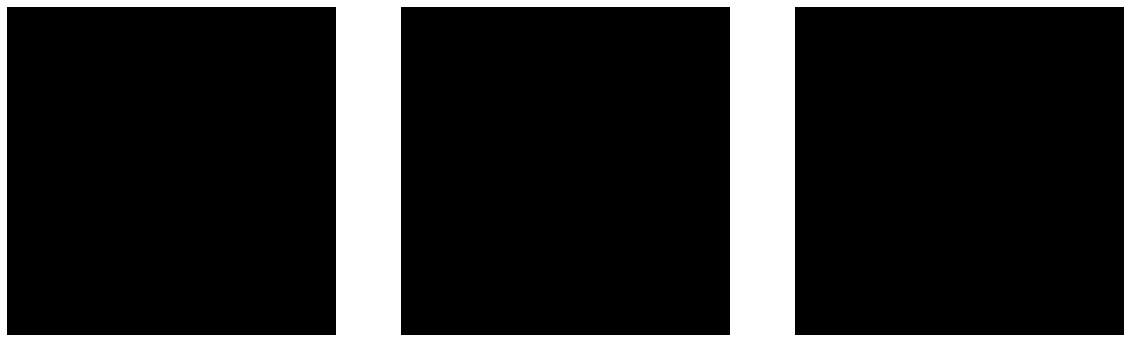

In [ ]:
COLORS = {
    "red": (255, 0, 0),
    "green": (0, 255, 0),
    "blue": (0, 255, 0),
    "purple": (255, 0, 255),
    "orange": (255, 127, 127),
    "gray": (127, 127, 127),
    "yellow": (0, 0, 255),
    "white": (255, 255, 255),
}

def draw_shape(img, pos, size, shape, color):
    if shape == "square":
        cv.rectangle(img, pos, (pos[0]+size, pos[1]+size), color, -1)

    elif shape == "circle":
        cv.circle(img, pos, size//2, color, -1)

    elif shape == "triangle":
        cv.fillPoly(img, [np.array([
            (pos[0] - size//2, pos[1] + size//2),
            (pos[0] + size//2, pos[1] + size//2),
            (pos[0], pos[1] - size//2),
        ])],
        color, 
        )

images = list()
sampled_scenes = random.sample(all_satisfied_scenes, 3)

for scene in sampled_scenes:
    WIDTH, HEIGHT = 512, 512
    STRIDE = WIDTH//10
    img = np.zeros((WIDTH, HEIGHT, 3), np.uint8)

    for obj in scene:
        draw_shape(img,
                   (np.array(obj["pos"])*WIDTH).astype(int),
                   5+int(STRIDE*1.5*obj["size"]),
                   obj["shape"],
                   COLORS[obj["color"]])

    # Add to the collection.
    images.append(img)

# Draw the generated images.
fig = plt.figure(figsize=(20, 20))

for i in range(3):
    fig.add_subplot(1, 3, 1+i)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()